In [2]:
import pandas as pd

In [3]:
import tensorflow as tf

In [9]:
import sys
print(sys.version)
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy
from ipywidgets import interact, widgets
from scipy import stats
import seaborn as sns
import os
import json
from pprint import pprint
import cv2

3.6.5 (default, Jun 17 2018, 12:13:06) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


In [13]:
numGrids = 12
features = []
for file in os.listdir("./imageLabel/."):
    if(file.endswith(")")):
        print("Extracting labels from file " + file)
        data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
        img = cv2.imread("../../East Team S2 2/" + file + ".jpg")
        if 'labels' in data:
            height, width, channels = img.shape
            gheight, gwidth = int(height/numGrids) , int(width/numGrids)
            for index, gridLabel in enumerate(data['labels']):
                if gridLabel:
                    rowIndex = index % numGrids
                    colIndex = int(index / numGrids)
                    grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth, :]
                    blur = cv2.resize(img, (256, 256))
                    
                    #feature extraction
                    featureList = []
                    gridRed = grid[:,:,0]
                    gridGreen = grid[:,:,1]
                    gridBlue = grid[:,:,2]
                    rbar = np.average(gridRed)
                    gbar = np.average(gridGreen)
                    bbar = np.average(gridBlue)
                    featureList.append(rbar)
                    featureList.append(gbar)
                    featureList.append(bbar)
                    featureList += np.bincount(np.ravel((gridRed/32).astype(int)), minlength = 8).tolist()
                    featureList += np.bincount(np.ravel((gridGreen/32).astype(int)), minlength = 8).tolist()
                    featureList += np.bincount(np.ravel((gridBlue/32).astype(int)), minlength = 8).tolist()

                    features.append(featureList)
                    
                    
                    

Extracting labels from file A (108)
Extracting labels from file A (141)
Extracting labels from file A (187)
Extracting labels from file A (30)
Extracting labels from file A (127)
Extracting labels from file A (164)
Extracting labels from file A (15)
Extracting labels from file A (200)
Extracting labels from file A (102)
Extracting labels from file A (184)
Extracting labels from file A (142)
Extracting labels from file A (124)
Extracting labels from file A (9)
Extracting labels from file A (33)
Extracting labels from file A (39)
Extracting labels from file A (3)
Extracting labels from file A (167)
Extracting labels from file A (148)
Extracting labels from file A (101)
Extracting labels from file A (16)
Extracting labels from file A (22)
Extracting labels from file A (135)
Extracting labels from file A (153)
Extracting labels from file A (195)
Extracting labels from file A (44)
Extracting labels from file A (110)
Extracting labels from file A (159)
Extracting labels from file A (176)
Ext

In [14]:
features = np.asarray(features)
features = features / features.max(axis=0)

In [15]:
features.shape

(6319, 27)

In [7]:
train_X = np.load('Xmatrix.npy')
train_Y = np.load('Ylabels.npy')
print('Training data shape : ', train_X.shape, train_Y.shape)

# set dimensions of a small sized image for a single data point

height = 224
width = 224
numGrids = 12 

Training data shape :  (4320, 150528) (4320, 1)


In [8]:
# X is the full training data Matrix, e.g. (4320, 150528), i is the index of the image that you want to plot
def plotFull(X, i):
    allPieces = train_X.reshape(-1, height, width, 3)
    imagePieces = allPieces[numGrids**2*i:numGrids**2*(i + 1)]
    if np.ravel(imagePieces)[0] > 1:
        imagePieces = imagePieces / 255.
    fullImage = reconstructPic(imagePieces, numGrids)
    plt.imshow(fullImage)
    
# X is (numGrids**2, height * width), this method return a high resolution picture with the image pieces
def reconstructPic(X, numGrids):  
    reconstruction = np.zeros((len(X[0]) * numGrids, (len(X[0][0])) * numGrids, 3))
    width = len(X[0][0])
    imgwidth = int(len(X[0][0]) * numGrids)
    height = len(X[0])
    imgheight = int(len(X[0]) * numGrids)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            result = X[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))].reshape(height, width, -1)
            reconstruction[i:i+height, j:j+width,:] = result
    return reconstruction

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


(2688, 2688, 3)


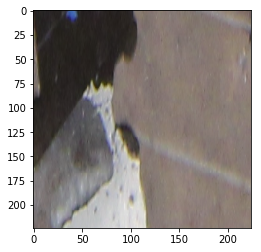

In [11]:
def getGrid(wholeIndex=4,gridIndex =0): 
    whole = reconstructPic(train_X.reshape(-1, height, width, 3)[numGrids**2*wholeIndex:numGrids**2*(wholeIndex + 1)]/255.,numGrids)
    #plt.imshow(whole)
    print(whole.shape)
    grid = whole[gridIndex%12*height:((gridIndex)%12 + 1)*height,int(gridIndex/12)*height:int((gridIndex)/12 + 1)*width,:]
    return grid
sns.reset_orig()
plt.imshow(getGrid(8,35))

In [12]:
interact(lambda lam: plotFull(train_X, lam), lam=(0, int(len(train_X)/numGrids**2)-1))

interactive(children=(IntSlider(value=14, description='lam', max=29), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(lam)>

Feature Extracting Themes
1. Input Vector: RGB-bar (3)
2. RGB-frequencies into 8 factors histograms (8 * 3)
3. 256 gradient map (8 * 3)
4. Hue, Saturation, Lightness

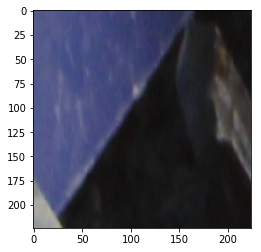

In [224]:
grid = train_X[999,:].reshape(224,224,3)
plt.imshow(grid)

1035411


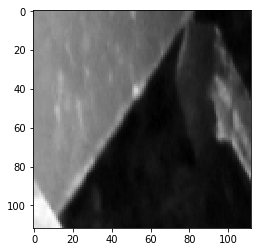

In [220]:
import cv2
grid = train_X[999,:].reshape(224,224,3)
blurFactor = 2
img = cv2.resize(uint8(grid), (int(224/blurFactor),int(224/blurFactor)))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(sum(img[:-1] - img[1:]))
plt.imshow(img, cmap='gray')

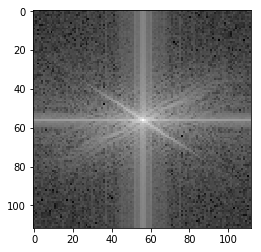

In [225]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
mag_spec = 20 * np.log(np.abs(fshift))

plt.imshow(mag_spec/255.)

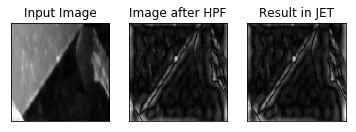

(112, 112)

In [227]:
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
factor = 5
fshift[(crow-factor):(crow+factor), (ccol-factor):(ccol+factor)] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back/255., cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back/255.)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()
img_back.shape

In [226]:
n = len(train_X)
features = []
for i in range(n):
    grid = train_X[i,:].reshape(224,224,3)
    featureList = []
    gridRed = grid[:,:,0]
    gridGreen = grid[:,:,1]
    gridBlue = grid[:,:,2]
    if(np.ravel(gridRed)[0] < 1):
        gridRed *= 255.
        gridGreen *= 255.
        gridBlue *= 255.
    rbar = np.average(gridRed)
    gbar = np.average(gridGreen)
    bbar = np.average(gridBlue)
    featureList.append(rbar)
    featureList.append(gbar)
    featureList.append(bbar)
    featureList += np.bincount(np.ravel((gridRed/32).astype(int)), minlength = 8).tolist()
    featureList += np.bincount(np.ravel((gridGreen/32).astype(int)), minlength = 8).tolist()
    featureList += np.bincount(np.ravel((gridBlue/32).astype(int)), minlength = 8).tolist()
    
    features.append(featureList)
features = np.asarray(features)
features = features / features.max(axis=0)

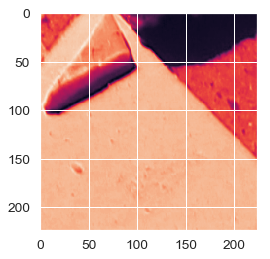

In [38]:
plt.imshow(gridBlue)

average 0.1684780775374386 variance 0.040219204719926765


C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


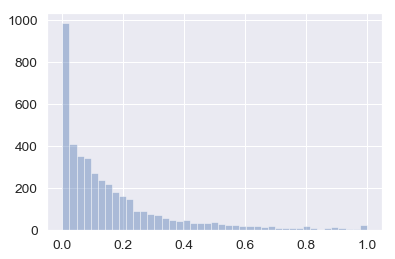

In [39]:
import seaborn as sns
colorIndex = 7
print("average", np.average(features[:,colorIndex]), "variance", np.var(features[:,colorIndex]))
sns.distplot(features[:,colorIndex],kde=False)

In [40]:
from sklearn.model_selection import train_test_split

# split dataset into 80% training data points and 20% testing data points

train_Y_one_hot = to_categorical(train_Y)
train_X,test_X,train_label,test_label = train_test_split(features, train_Y_one_hot, test_size=0.2, random_state=12)

print('Training data shape : ', train_X.shape, train_label.shape, 'Testing data shape: ', test_X.shape, test_label.shape)

Training data shape :  (3456, 27) (3456, 2) Testing data shape:  (864, 27) (864, 2)


In [41]:
# identify the number of classes and 

classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0. 1.]


In [42]:
print("Python list train_X with length", train_X.shape, "is converted to a numpy array")

train_X = train_X.reshape(-1, 27)
print(train_X.shape)

train_X = train_X.astype('float32')

if np.ravel(train_X)[0] > 1:
    train_X = train_X / 255.

train_Y_one_hot = to_categorical(train_Y)
print('Original label:\n', train_Y[0:6])
print('After conversion to one-hot:\n', train_Y_one_hot[0:6])

Python list train_X with length (3456, 27) is converted to a numpy array
(3456, 27)
Original label:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
After conversion to one-hot:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [43]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2, random_state=13)
print('Training data shape : ', train_X.shape, train_label.shape, 'Validing data shape: ', valid_X.shape, valid_label.shape)

Training data shape :  (2764, 27) (2764, 2) Validing data shape:  (692, 27) (692, 2)


In [44]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import normalize

In [45]:
batch_size = 64
epochs = 120
num_classes = 2

model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(27,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [46]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 1,330
Trainable params: 1,330
Non-trainable params: 0
_________________________________________________________________


In [48]:
tf.contrib.training.HParams(learning_rate=0.1, num_hidden_units=100)

HParams([('learning_rate', 0.1), ('num_hidden_units', 100)])

In [49]:
result = model.fit(features, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 4320 samples, validate on 692 samples
Epoch 1/120
4320/4320 [==============================] - 1s 269us/step - loss: 0.6608 - acc: 0.6106 - val_loss: 0.6280 - val_acc: 0.6691
Epoch 2/120
4320/4320 [==============================] - 0s 49us/step - loss: 0.6090 - acc: 0.6813 - val_loss: 0.5912 - val_acc: 0.6879
Epoch 3/120
4320/4320 [==============================] - 0s 47us/step - loss: 0.5738 - acc: 0.7037 - val_loss: 0.5689 - val_acc: 0.6850
Epoch 4/120
4320/4320 [==============================] - 0s 31us/step - loss: 0.5535 - acc: 0.7083 - val_loss: 0.5512 - val_acc: 0.7023
Epoch 5/120
4320/4320 [==============================] - 0s 30us/step - loss: 0.5398 - acc: 0.7176 - val_loss: 0.5407 - val_acc: 0.7153
Epoch 6/120
4320/4320 [==============================] - 0s 31us/step - loss: 0.5280 - acc: 0.7299 - val_loss: 0.5308 - val_acc: 0.7341
Epoch 7/120
4320/4320 [==============================] - 0s 39us/step - loss: 0.5200 - acc: 0.7447 - val_loss: 0.5187 - val_acc: 0.7428


Epoch 120/120
4320/4320 [==============================] - 0s 29us/step - loss: 0.4113 - acc: 0.8111 - val_loss: 0.4288 - val_acc: 0.8078


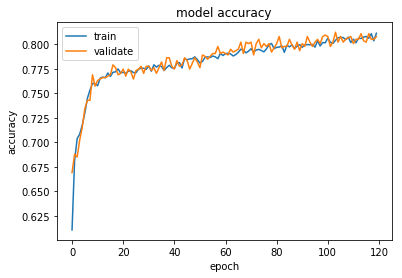

In [51]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

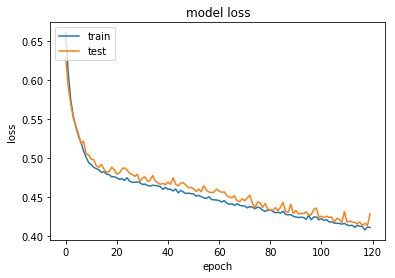

In [52]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
k = model.predict_classes(test_X)

In [54]:
sum(k == test_label[:,1])/len(k)

0.8078703703703703

In [55]:
regularization = 0.00001
weight = np.linalg.inv(features.T.dot(features)+regularization * np.eye(27)).dot(features.T).dot(train_Y)
weight.reshape(-1,)

array([ 2.49523728,  5.11511585, -2.52350927,  2.11183513,  1.54584176,
        0.15129593, -0.45746164, -0.92075067, -1.36568515, -3.05841018,
       -3.37590951, -1.76355691, -0.86761998, -0.59307801, -0.96411487,
       -1.48369219, -1.02723176,  0.30699344,  1.17651482, -0.2138616 ,
       -0.64929622, -0.43447437, -0.80985676, -0.2045153 , -0.00856067,
       -0.59469316, -2.29077796])

In [56]:
import seaborn as sns
featuresPd = pd.DataFrame(features)
featuresPd.columns = ["Red-bar","Green-bar","Blue-bar",
                      "Red lvl 1","Red lvl 2","Red lvl 3","Red lvl 4","Red lvl 5","Red lvl 6","Red lvl 7","Red lvl 8",
"Green lvl 1","Green lvl 2","Green lvl 3","Green lvl 4","Green lvl 5","Green lvl 6","Green lvl 7","Green lvl 8",
"Blue lvl 1","Blue lvl 2","Blue lvl 3","Blue lvl 4","Blue lvl 5","Blue lvl 6","Blue lvl 7","Blue lvl 8"]
featuresPd['label'] = pd.Series(train_Y.reshape(-1,), index=featuresPd.index)
corrMat = featuresPd.corr()

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


(2688, 2688, 3)


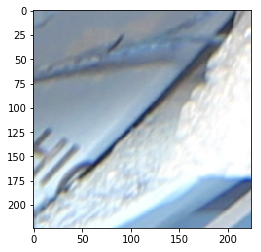

In [59]:
sns.reset_orig()
plt.imshow(getGrid(8,35))

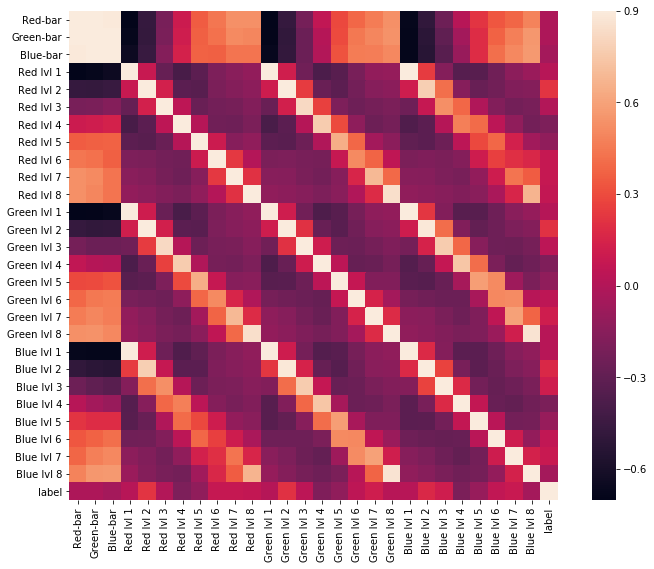

In [60]:
plt.subplots(figsize=(12,9))
corrMat = featuresPd.corr()
sns.heatmap(corrMat, vmax=0.9, square=True)

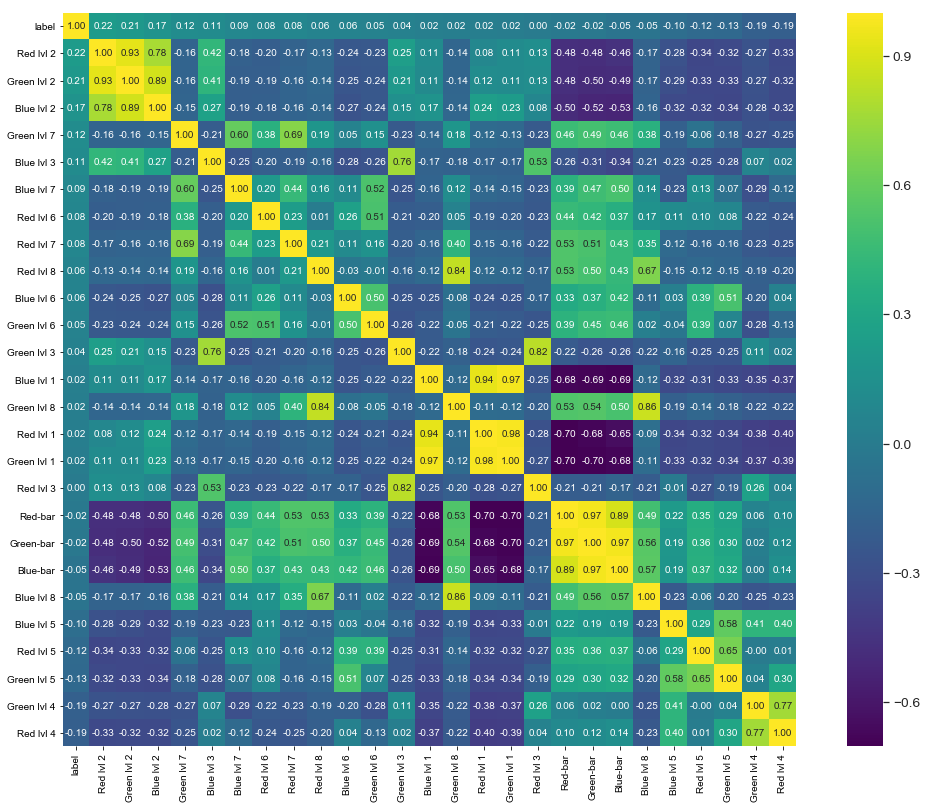

In [61]:
k = 27 #number of variables for heatmap
plt.subplots(figsize=(18,13.5))
cols = corrMat.nlargest(k, 'label')['label'].index
cm = np.corrcoef(featuresPd[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap= 'viridis',cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [134]:
sum((test_X.dot(weight)+0.5).astype(int).reshape(-1,) == test_label[:,1])/len(test_X)

0.6875

In [84]:
sum(test_label[:,1].astype(int) == k)/len(k)

0.8078703703703703

In [85]:
def voteMap(X, p, numGrids, job, graf):
    vmap = np.zeros((len(X[0]) * numGrids, (len(X[0][0])) * numGrids, 3))
    width = len(X[0][0])
    imgwidth = int(len(X[0][0]) * numGrids)
    height = len(X[0])
    imgheight = int(len(X[0]) * numGrids)
    cnt = 1
    if(graf):
        fig=plt.figure(figsize=(7.5, 5))
        plt.title('Votes')
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            colorVote = X[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))].reshape(height, width, -1)
            percentageCorrect = p[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))]

#            if job > 0:
#                if k[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))] == 0:
#                   colorVote[:] = (1, 0, 0)
#           else:
#               if k[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))] > 0:
#                   colorVote[:] = (1, 0, 0)
            if(job == 0):
                vmap[i:i+height, j:j+width,:] = colorVote * percentageCorrect
            else:
                vmap[i:i+height, j:j+width,:] = colorVote * percentageCorrect
            if(graf):
                temp = vmap[i:i+height, j:j+width,:]
                ax = fig.add_subplot(rows, columns, cnt)
                cnt += 1
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(temp)
    return vmap


In [86]:
import matplotlib as mpl
def voteColor(X, p, numGrids, job, graf):
    vmap = np.zeros((len(X[0]) * numGrids, (len(X[0][0])) * numGrids, 3))
    width = len(X[0][0])
    imgwidth = int(len(X[0][0]) * numGrids)
    height = len(X[0])
    imgheight = int(len(X[0]) * numGrids)
    cnt = 1
    if(graf):
        fig=plt.figure(figsize=(7.5, 5))
        plt.title('Votes')
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            colorVote = X[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))].reshape(height, width, -1)
            percentageCorrect = p[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))]

#            if job > 0:
#                if k[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))] == 0:
#                   colorVote[:] = (1, 0, 0)
#           else:
#               if k[int(numGrids*i/len(X[0])) +int(j/len(X[0][0]))] > 0:
#                   colorVote[:] = (1, 0, 0)
            colorVote[:] = mpl.cm.inferno(percentageCorrect)[0:3]
            colorVote[:] = (0, 1, 0)
            if(job < 1):
                vmap[i:i+height, j:j+width,:] = (1 - percentageCorrect, percentageCorrect, 0)
            else:
                vmap[i:i+height, j:j+width,:] = (percentageCorrect, 1 - percentageCorrect, 0)
            if(graf):
                temp = vmap[i:i+height, j:j+width,:]
                ax = fig.add_subplot(rows, columns, cnt)
                cnt += 1
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(temp)
    return vmap


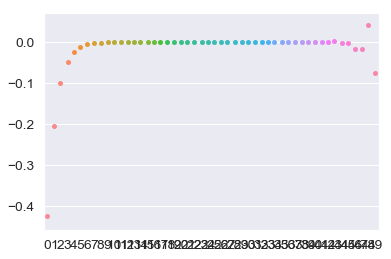

In [100]:
def fprime(x, h):
	return (np.sin(x+h) - np.sin(x))/h

def absoluteErr(h):
	return fprime(1, h) - np.cos(1)

def relativeErr(h):
    return absoluteErr(h)/np.cos(1)

def plotAbs(k = 10):
    x = np.arange(k)
    y = []
    for i in range(1, 1+k):
        two = 2**i
        y.append(relativeErr(1/two))
    y = np.array(y)
    sns.stripplot(x=x,y=y)
    plt.show()
plotAbs(50)

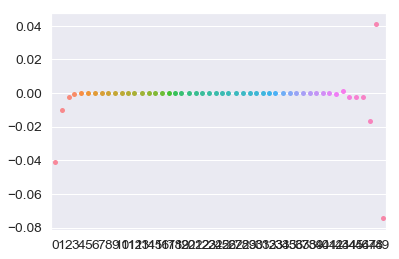

In [102]:
def fprime(x, h):
	return (np.sin(x+h) - np.sin(x-h))/(2*h)

def absoluteErr(h):
	return fprime(1, h) - np.cos(1)

def relativeErr(h):
    return absoluteErr(h)/np.cos(1)

def plotAbs(k = 10):
    x = np.arange(k)
    y = []
    for i in range(1, 1+k):
        two = 2**i
        y.append(relativeErr(1/two))
    y = np.array(y)
    sns.stripplot(x=x,y=y)
    plt.show()
plotAbs(50)

In [409]:
train_X.shape

(4320, 150528)

In [414]:
interact(lambda lam: plotFull(train_X, lam), lam=(0,29))

interactive(children=(IntSlider(value=14, description='lam', max=29), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(lam)>

In [ ]:
# accuracy = fashion_train_dropout.history['acc']
# val_accuracy = fashion_train_dropout.history['val_acc']
# loss = fashion_train_dropout.history['loss']
# val_loss = fashion_train_dropout.history['val_loss']
# epochs = range(len(accuracy))
# plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.legend()
# plt.show()

In [413]:
def plotVotes(id):
    X = np.copy(train_X[id*144:(id+1)*144])
    allVote = voteMap(X, k[id*144:(id+1)*144], 12, train_Y[id * 144], False)
    fig=plt.figure(figsize=(7.5, 5))
    columns = 12
    rows = 12
    plt.title('Votes')
    for i in range(1, columns*rows +1):
        row = int((i - 1)/rows)
        col = int((i - 1)%rows)
        img = allVote[row*96:row*96+96,col*144:col*144+144,:]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    plt.savefig('example.png')
    plt.show()